In [25]:
import sys
from pathlib import Path
sys.path.append("..")
import pandas as pd
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from simulation.rotor import MagneticBearing3D
from simulation.pid import PID
from simulation.seal import Seal
from simulation.excitation_signals import *
from simulation.generate_dataset import *

In [26]:
import os

data_dir = Path(f"../simulation/data/sin_simple/")

data = []
for file in filter(lambda x: x.endswith(".csv"), os.listdir(data_dir)):
    print(file)
    data.append(pd.read_csv(data_dir / Path(file)))

excitation_x_freq_14Hz_seal_False.csv
excitation_x_freq_14Hz_seal_True.csv
excitation_x_freq_19Hz_seal_False.csv
excitation_x_freq_19Hz_seal_True.csv
excitation_x_freq_24Hz_seal_False.csv
excitation_x_freq_24Hz_seal_True.csv
excitation_x_freq_29Hz_seal_False.csv
excitation_x_freq_29Hz_seal_True.csv
excitation_x_freq_34Hz_seal_False.csv
excitation_x_freq_34Hz_seal_True.csv
excitation_x_freq_39Hz_seal_False.csv
excitation_x_freq_39Hz_seal_True.csv
excitation_x_freq_44Hz_seal_False.csv
excitation_x_freq_44Hz_seal_True.csv
excitation_x_freq_49Hz_seal_False.csv
excitation_x_freq_49Hz_seal_True.csv
excitation_x_freq_4Hz_seal_False.csv
excitation_x_freq_4Hz_seal_True.csv
excitation_x_freq_9Hz_seal_False.csv
excitation_x_freq_9Hz_seal_True.csv
excitation_y_freq_14Hz_seal_False.csv
excitation_y_freq_14Hz_seal_True.csv
excitation_y_freq_19Hz_seal_False.csv
excitation_y_freq_19Hz_seal_True.csv
excitation_y_freq_24Hz_seal_False.csv
excitation_y_freq_24Hz_seal_True.csv
excitation_y_freq_29Hz_seal_F

In [79]:
_df = pd.read_csv(data_dir / Path("excitation_y_freq_49Hz_seal_True.csv"))

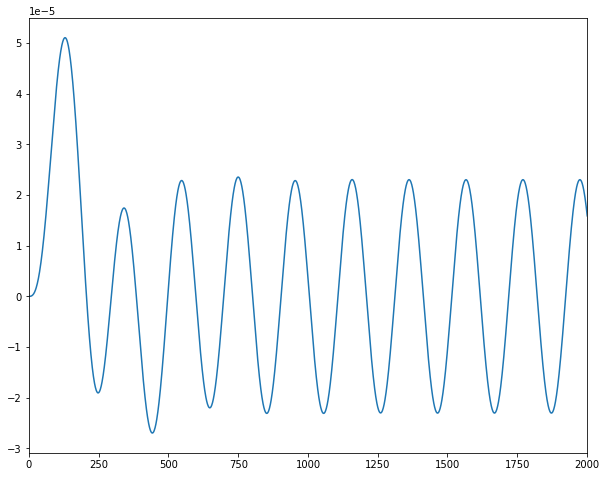

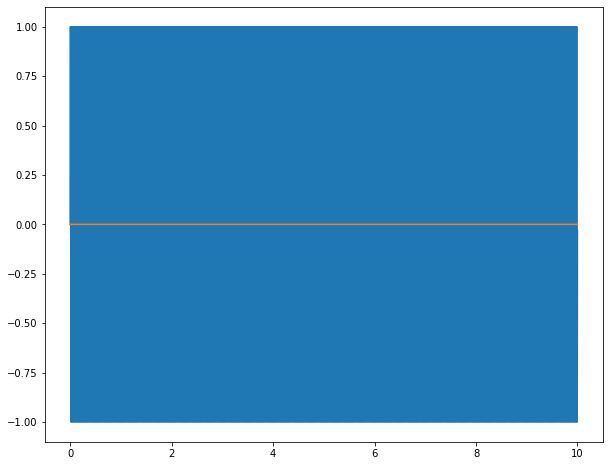

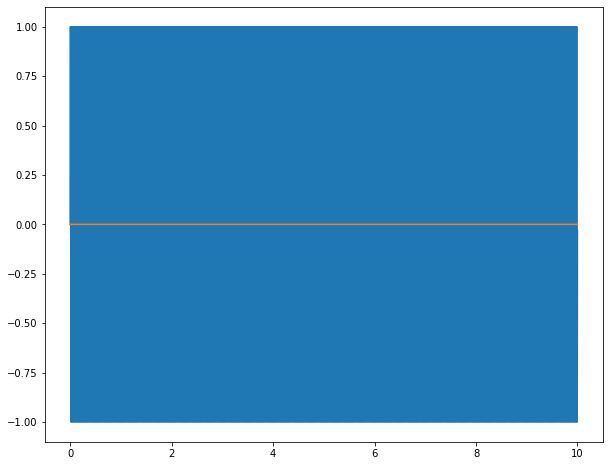

In [88]:
df = _df[_df.episode == 0]
plt.figure(figsize=(10,8))
plt.plot(df["ay"])
#plt.plot(df["t"], df["by"])
#plt.plot(df["ax"])
plt.xlim(0, 2000)
plt.show()

plt.figure(figsize=(10,8))
plt.plot(df["t"], df["f_ay"])
plt.plot(df["t"], df["f_ax"])
plt.show()

plt.figure(figsize=(10,8))
plt.plot(df["t"], df["fy"])
plt.plot(df["t"], df["fx"])
plt.show()

In [11]:
from estimators.frequency import EIVSin
from collections import Counter
from numpy.fft import fft, fftshift, fftfreq
%load_ext autoreload
%autoreload 2

In [46]:
def parse_info_from_filename(filename):
    
    filename = Path(filename).stem
    
    split = filename.split("_")
    if len(split) < 4:
        return None, None, None
    axis = split[1]
    frequency = float(split[3].replace("Hz", ""))
    seal = split[-1] == "True"
    
    return axis, frequency, seal
 

axis, frequency, seal = parse_info_from_filename("../simulation/data/sin_simple/excitation_x_freq_4Hz_seal_False.csv")
assert axis == "x"
assert frequency == 4
assert seal == False

In [87]:
def filter_files(x, axis, frequency, seal):
    _axis, _frequency, _seal = parse_info_from_filename(x)
    return (_axis == axis) and (_frequency == frequency) and (_seal == seal)

def estimate_file_coefficient(data_dir, freq, seal=False):
    
    estimator = EIVSin()
    
    file_x = next(filter(lambda x: filter_files(x, "x", freq, seal), os.listdir(data_dir)))
    file_y = next(filter(lambda x: filter_files(x, "y", freq, seal), os.listdir(data_dir)))
    
    df_x = pd.read_csv( Path(data_dir) / Path(file_x) )
    df_y = pd.read_csv( Path(data_dir) / Path(file_y) )
    
    
    w = estimator.estimate(df_x=df_x.iloc[2000:],
                            df_y=df_y.iloc[2000:],
                            freq=freq)
    
    return w



data_dir = Path(f"../simulation/data/sin_simple/")

    
def estimate_coefficients_for_frequency(data_dir, freq):

    seal = True
    ws = estimate_file_coefficient(data_dir, freq, seal)

    seal = False
    wos = estimate_file_coefficient(data_dir, freq, seal)
    
    coeffs = dict(K=ws["K"] - wos["K"],
                  C=ws["C"] - wos["C"],
                  freq=freq)
    return coeffs

def estimate_coefficients(data_dir):
    
    freqs = map(lambda x: parse_info_from_filename(x)[1], os.listdir(data_dir))
    freqs = filter(lambda x: bool(x), freqs)
    freqs = np.unique(list(freqs))
    
    data = []
    for freq in freqs:
        w = estimate_coefficients_for_frequency(data_dir, int(freq))
        data.append({ "freq" : freq,
                      "w" : w})
    return data
        



estimate_coefficients(data_dir)

19
19
44
44
68
68
93
93
117
117
142
142
166
166
191
191
215
215
239
239


[{'freq': 4.0,
  'w': {'K': array([[4302.51254204,  430.11208567],
          [-429.8569354 ,  432.56460289]]),
   'C': array([[ 4.25686510e+01, -5.01684847e-02],
          [ 3.53068156e-02,  4.29548563e+01]]),
   'freq': 4}},
 {'freq': 9.0,
  'w': {'K': array([[4313.58899205,  429.98114239],
          [-429.85910887,  444.0752277 ]]),
   'C': array([[ 4.25555543e+01, -4.53757806e-02],
          [ 4.04557245e-02,  4.29420180e+01]]),
   'freq': 9}},
 {'freq': 14.0,
  'w': {'K': array([[4333.5416117 ,  429.82556661],
          [-429.7819414 ,  464.63856712]]),
   'C': array([[ 4.25612181e+01, -4.97116570e-02],
          [ 3.83534701e-02,  4.29536128e+01]]),
   'freq': 14}},
 {'freq': 19.0,
  'w': {'K': array([[4362.59075629,  429.21665266],
          [-430.38061998,  493.88661942]]),
   'C': array([[ 4.25681422e+01, -6.09854439e-02],
          [ 3.05445009e-02,  4.29715631e+01]]),
   'freq': 19}},
 {'freq': 24.0,
  'w': {'K': array([[4401.22287535,  431.65200307],
          [-427.94676202

In [89]:
f = 4

estimator = EIVSin()

df_x = pd.read_csv(f"../simulation/data/debug/excitation_x_freq_{f}Hz_seal_True.csv")
df_y = pd.read_csv(f"../simulation/data/debug/excitation_y_freq_{f}Hz_seal_True.csv")


ws = estimator.estimate(df_x=df_x,
                        df_y=df_y,
                        freq=f)

ws

9


{'freq': 4,
 'G': array([[3987.8749791 +1071.17905861j,  428.00072642   -1.20499676j],
        [-428.00072642   +1.20499676j,  135.86844129+1082.02402941j]]),
 'C': array([[42.62086053, -0.0479453 ],
        [ 0.0479453 , 43.05236821]]),
 'K': array([[4619.52966077,  428.00072642],
        [-428.00072642,  767.52312296]])}

In [59]:
f = 4
estimator = EIVSin()

xcitation_x_freq_4Hz_seal_False.csv
excitation_y_freq_4Hz_seal_False.csv

df_x = pd.read_csv(f"../simulation/data/sin_simple/excitation_x_freq_{f}Hz_seal_False.csv")
df_y = pd.read_csv(f"../simulation/data/sin_simple/excitation_y_freq_{f}Hz_seal_False.csv")


wos = estimator.estimate(df_x=df_x,
                        df_y=df_y,
                        freq=f)

wos

19


{'freq': 4,
 'G': array([[7.18304531e+03+424.55662872j, 2.93550743e+00 +23.60683602j],
        [2.93550743e+00 +23.60683602j, 7.18304531e+03+424.55662872j]]),
 'C': array([[16.89257152,  0.93928616],
        [ 0.93928616, 16.89257152]]),
 'K': array([[7.81469999e+03, 2.93550743e+00],
        [2.93550743e+00, 7.81469999e+03]])}

In [23]:
ws["K"] - wos["K"]

array([[4312.01569675,  429.92464299],
       [-423.32707437,  441.92013914]])

In [24]:
ws["C"] - wos["C"]

array([[42.65207864, -0.18050999],
       [-0.16056002, 43.05202086]])

In [13]:
if False:
    freq = 4
    dt = (df_x["t"] - df_y["t"].shift()).median()

    dfs = []
    for episode, group in df_x.groupby("episode"):
        temp = estimator.get_frequency_domain_data(df=group,
                                              freq=freq,
                                              dt=dt)
        temp["episode"] = episode
        dfs.append(temp)
    df_x = pd.concat(dfs, ignore_index=True)

    dfs = []
    for episode, group in df_y.groupby("episode"):
        temp = estimator.get_frequency_domain_data(df=group,
                                              freq=freq,
                                              dt=dt)
        temp["episode"] = episode
        dfs.append(temp)
    df_y = pd.concat(dfs, ignore_index=True)


    print(df_x.columns)
    print(df_y.columns)

    df = pd.concat([df_x, df_y], ignore_index=False)

    # Apenas frequencia de interesse
    sel_df = df[(df["freqs"] > freq - 2) & (df["freqs"] < freq + 1)].sort_index()
    # Apenas indices que exisitam no dataframe x e y
    inds = list(map(lambda x: x[0], (filter(lambda x: x[1] == 2, Counter(df.index).most_common()))))


    inds = list(filter(lambda  x: x in sel_df.index, inds))

    print(len(inds))
    sel_df = sel_df.loc[inds]
    sel_df
    
    Us = []
    Ys = []
    for name, group in sel_df.groupby(sel_df.index):
        U = group[["xf", "yf"]].values.transpose()
        Y = group[["fxf", "fyf"]].values.transpose()
        Us.append(U)
        Ys.append(Y)
    Us = np.array(Us)
    Ys = np.array(Ys)

    G = np.mean(Ys, axis=0) @ np.linalg.inv(np.mean(Us, axis=0))
    C = np.imag(G) / (2 * np.pi * freq)
    K = np.real(G) + (2 * np.pi * freq) ** 2 * np.array([[1, 0], [0, 1]])
    print(C, K)
    
    df = dfs[0]
    plt.scatter(df["freqs"], np.abs(df["fyf"]), s=1)
    plt.xlim((-10, 10))
    plt.show()

    plt.scatter(df["freqs"], np.abs(df["yf"]), s=1)
    plt.xlim((-35, 35))
    plt.show()

In [62]:
ws["K"] - wos["K"]

NameError: name 'wos' is not defined

In [23]:
freq = 9

dt = (df_x["t"] - df_y["t"].shift()).median()

df_x = estimator.get_frequency_domain_data(df=df_x,
                                      freq=freq,
                                      dt=dt)

df_y = estimator.get_frequency_domain_data(df=df_y,
                                      freq=freq,
                                      dt=dt)

df = pd.concat([df_x, df_y], ignore_index=False)

# Apenas frequencia de interesse
sel_df = df[(df["freqs"] > freq - 2) & (df["freqs"] < freq + 1)].sort_index()
# Apenas indices que exisitam no dataframe x e y
inds = list(map(lambda x: x[0], (filter(lambda x: x[1] == 2, Counter(sel_df.index).most_common()))))



inds = list(filter(lambda  x: x in sel_df.index, inds))

print(len(inds))
sel_df = sel_df.loc[inds]

KeyError: 't'

In [ ]:
Us = []
Ys = []
for name, group in sel_df.groupby(sel_df.index):
    U = group[["xf", "yf"]].values.transpose()
    Y = group[["fxf", "fyf"]].values.transpose()
    Us.append(U)
    Ys.append(Y)
Us = np.array(Us)
Ys = np.array(Ys)

G = np.mean(Ys, axis=0) @ np.linalg.inv(np.mean(Us, axis=0))
C = np.imag(G) / (2 * np.pi * freq)
K = np.real(G) + (2 * np.pi * freq) ** 2 * np.array([[1, 0], [0, 1]])